## 1.1 Getting started

First we must load in our time series - a history of around 140 days of Apple's stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but it is also commonplace to normalize by a series standard deviation.

In [ ]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
df = pd.read_csv('datasets/IRB.csv')
dataset = df['Turnover (Lacs)']
dataset = (dataset - dataset.min(axis=0))/(dataset.max(axis=0) - dataset.min(axis=0)) # normalize

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

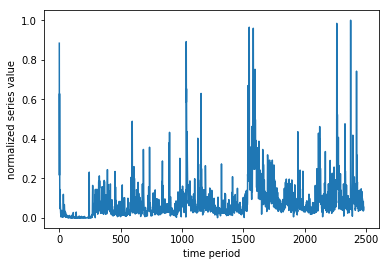

In [ ]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/Vatshayan/stock-price-prediction/blob/master/images/timeseries_windowing_training.gif?raw=1" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now its time for you to window the input time series as described above!  

<a id='TODO_1'></a>

**TODO:** Implement the function called **window_transform_series** in my_answers.py so that it runs a sliding window along the input series and creates associated input/output pairs.    Note that this function should input a) the series and b) the window length, and return the input/output subsequences.  Make sure to format returned input/output as generally shown in table above (where window_size = 5), and make sure your returned input is a numpy array.

-----

In [ ]:
# window the data using your windowing function
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []
    for window in range(len(series) - window_size):
        X.append(series[window:window+window_size])
        y.append(series[window + window_size])
    # reshape each
    X = np.asarray(X)
    #X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    return X,y

window_size = 12
X,y = window_transform_series(series = dataset,window_size = window_size)

## 1.3  Splitting into training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [ ]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize]
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))
print(X_train[0])

[[ 0.88381759]
 [ 0.21606575]
 [ 0.62858825]
 [ 0.34456389]
 [ 0.08453266]
 [ 0.14340066]
 [ 0.09602644]
 [ 0.04648937]
 [ 0.07609635]
 [ 0.05189349]
 [ 0.04794054]
 [ 0.02528959]]


<a id='TODO_2'></a>

## 1.4  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/)

(given in the cell below).  (remember to copy your completed function into the script *my_answers.py* function titled *build_part1_RNN* before submitting your project)

In [ ]:
### TODO: create required RNN model
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)


# TODO: implement build_part1_RNN in my_answers.py
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1), dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1))

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


With your model built you can now fit the model by activating the cell below!  Note: the number of epochs (np_epochs) and batch_size are preset (so we can all produce the same results).  You can choose to toggle the verbose parameter - which gives you regular updates on the progress of the algorithm - on and off by setting it to 1 or 0 respectively.

In [ ]:
# run your mo4del!
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1)

Epoch 1/100
1646/1646 [==============================] - 2s 921us/step - loss: 0.0065
Epoch 2/100
1646/1646 [==============================] - 0s 264us/step - loss: 0.0053

## 1.5  Checking model performance

With your model fit we can now make predictions on both our training and testing sets.

In [ ]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In the next cell we compute training and testing errors using our trained model - you should be able to achieve at least

*training_error* < 0.02

and

*testing_error* < 0.02

with your fully trained model.  

If either or both of your accuracies are larger than 0.02 re-train your model - increasing the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting your batch_size.

In [ ]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.00420825317319
testing error = 0.0062435781654


Activating the next cell plots the original data, as well as both predictions on the training and testing sets.

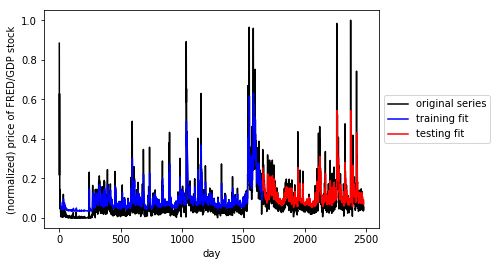

In [ ]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series/
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of FRED/GDP stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Note:** you can try out any time series for this exercise!  If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!